In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Kaggle API

In [ ]:
!pip install -q kaggle

#create a kaggle folder
!mkdir ~/.kaggle

#copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

#to list all the available dataset in kaggle
!kaggle datasets list

#take the kaggle dataset
!kaggle datasets download -d sushmit0109/subescobangla-speech-emotion-dataset

!unzip subescobangla-speech-emotion-dataset.zip

import zipfile

# Define the paths to the dataset zip files in Google Drive

subescobangla_dataset_zip = '/content/subescobangla-speech-emotion-dataset.zip'


with zipfile.ZipFile(subescobangla_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/subescobangla-speech-emotion-dataset')

from pathlib import Path

# Define the paths to the data directories

SUBESCO_DIR = Path('/content/subescobangla-speech-emotion-dataset/SUBESCO')

# List the file paths

subesco_filepaths = list(SUBESCO_DIR.glob('*.wav'))


print(f'Number of SUBESCO audio files: {len(subesco_filepaths)}')

subesco_filepaths[:10]

# identify emotions from the subesco dataset
audio_files = [path.name for path in subesco_filepaths]


contributor_name = [item.split("_")[2] for item in audio_files]
emotion_label = [filename.split("_")[5] for filename in audio_files]

print(set(emotion_label))

# Total Number of Contributors and Types of emotions in the audio files
unique = set(contributor_name)
type_of_emotions = set(emotion_label)

print(f"There are total {len(unique)} numbers of people contributed in this dataset for {len(type_of_emotions)} different emotions")

Streaming output truncated to the last 5000 lines.
  inflating: SUBESCO/F_06_SIMI_S_7_DISGUST_4.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_DISGUST_5.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_FEAR_1.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_FEAR_2.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_FEAR_3.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_FEAR_4.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_FEAR_5.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_HAPPY_1.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_HAPPY_2.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_HAPPY_3.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_HAPPY_4.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_HAPPY_5.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_NEUTRAL_1.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_NEUTRAL_2.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_NEUTRAL_3.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_NEUTRAL_4.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_NEUTRAL_5.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_SAD_1.wav  
  inflating: SUBESCO/F_06_SIMI_S_7_SAD_2.wav  
  inflating: 

In [ ]:
# appending emotion_label for the audio dataframe
filepaths = pd.Series(subesco_filepaths, name='Filepath').astype(str)
contributor_label = pd.Series(contributor_name, name='Contributor')
labels = pd.Series(emotion_label, name='Label')


audio_df = pd.concat([filepaths, contributor_label,  labels], axis=1)
audio_df['Index'] = audio_df.index
print(audio_df)

audio_df.sample(10)

                                               Filepath Contributor     Label  \
0     /content/subescobangla-speech-emotion-dataset/...    SHUMANTA      FEAR   
1     /content/subescobangla-speech-emotion-dataset/...        EVAN      FEAR   
2     /content/subescobangla-speech-emotion-dataset/...       SIBLY   DISGUST   
3     /content/subescobangla-speech-emotion-dataset/...    SHUKANTO     HAPPY   
4     /content/subescobangla-speech-emotion-dataset/...       SIBLY      FEAR   
...                                                 ...         ...       ...   
6995  /content/subescobangla-speech-emotion-dataset/...       SMITA     HAPPY   
6996  /content/subescobangla-speech-emotion-dataset/...       NIPUN     ANGRY   
6997  /content/subescobangla-speech-emotion-dataset/...    SHUMANTA     HAPPY   
6998  /content/subescobangla-speech-emotion-dataset/...       TITHI  SURPRISE   
6999  /content/subescobangla-speech-emotion-dataset/...    SWARNALI   DISGUST   

      Index  
0         0  

Filepath Contributor     Label  \
6395  /content/subescobangla-speech-emotion-dataset/...    SWARNALI       SAD   
140   /content/subescobangla-speech-emotion-dataset/...      PRASUN   NEUTRAL   
1156  /content/subescobangla-speech-emotion-dataset/...    SHUMANTA  SURPRISE   
2703  /content/subescobangla-speech-emotion-dataset/...       MOUNI  SURPRISE   
4837  /content/subescobangla-speech-emotion-dataset/...       OISHI   NEUTRAL   
2648  /content/subescobangla-speech-emotion-dataset/...       SMITA   NEUTRAL   
622   /content/subescobangla-speech-emotion-dataset/...    SHUMANTA  SURPRISE   
5317  /content/subescobangla-speech-emotion-dataset/...    SHUKANTO      FEAR   
5942  /content/subescobangla-speech-emotion-dataset/...    SWARNALI  SURPRISE   
2229  /content/subescobangla-speech-emotion-dataset/...      FAHMEE   DISGUST   

      Index  
6395   6395  
140     140  
1156   1156  
2703   2703  
4837   4837  
2648   2648  
622     622  
5317   5317  
5942   5942  
2229   2229

# Dataset Visualization

<Axes: xlabel='Label', ylabel='Count'>

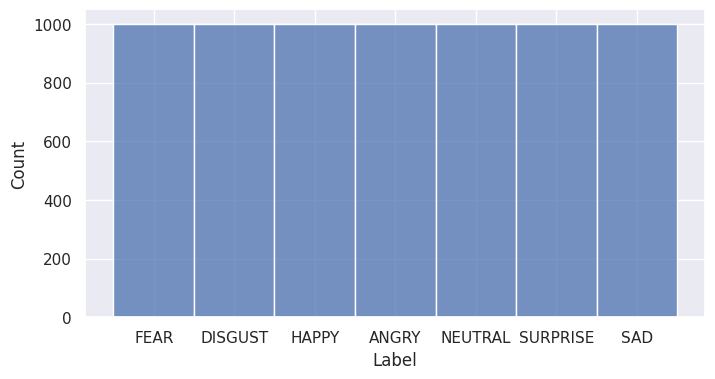

In [ ]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('darkgrid')
sns.histplot(labels, color='b')

In [ ]:
audio_arrays = []

for i in audio_df['Filepath']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)

audio_df['Arrays'] = audio_arrays

audio_df

Filepath Contributor     Label  \
0     /content/subescobangla-speech-emotion-dataset/...    SHUMANTA      FEAR   
1     /content/subescobangla-speech-emotion-dataset/...        EVAN      FEAR   
2     /content/subescobangla-speech-emotion-dataset/...       SIBLY   DISGUST   
3     /content/subescobangla-speech-emotion-dataset/...    SHUKANTO     HAPPY   
4     /content/subescobangla-speech-emotion-dataset/...       SIBLY      FEAR   
...                                                 ...         ...       ...   
6995  /content/subescobangla-speech-emotion-dataset/...       SMITA     HAPPY   
6996  /content/subescobangla-speech-emotion-dataset/...       NIPUN     ANGRY   
6997  /content/subescobangla-speech-emotion-dataset/...    SHUMANTA     HAPPY   
6998  /content/subescobangla-speech-emotion-dataset/...       TITHI  SURPRISE   
6999  /content/subescobangla-speech-emotion-dataset/...    SWARNALI   DISGUST   

      Index                                             Arrays  
0         0  [-2.916008e-05, 2.8359256e-05, -1.5344198e-05,...  
1         1  [-1.260246e-06, 9.0339944e-07, -5.966788e-07, ...  
2         2  [2.1172644e-05, -3.1534382e-05, 1.6082906e-05,...  
3         3  [0.0004533978, -0.0013526379, 0.00062154443, 0...  
4         4  [0.0, 3.0517578e-05, -6.1035156e-05, 6.1035156...  
...     ...                                                ...  
6995   6995  [-0.0013580322, -0.0015869141, -0.0011138916, ...  
6996   6996  [-3.0517578e-05, 6.1035156e-05, -6.1035156e-05...  
6997   6997  [-9.787027e-06, 1.8909288e-05, -3.002059e-05, ...  
6998   6998  [-2.387821e-05, 7.6059077e-06, 1.30425815e-05,...  
6999   6999  [0.0, 0.0, 0.0, 1.5258789e-05, -3.0517578e-05,...  

[7000 rows x 5 columns]

# ANGRY

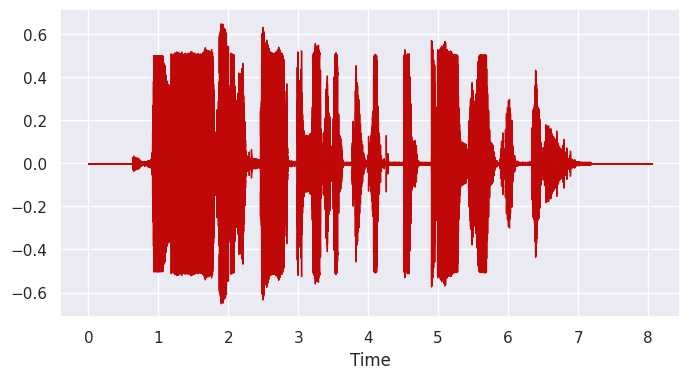

In [ ]:
angry = audio_df[audio_df['Label'] == 'ANGRY']['Filepath']
angryarray = audio_df[audio_df['Label'] == 'ANGRY']['Arrays']

librosa.display.waveshow(angryarray.iloc[0], color='#C00808')
IPython.display.Audio(angry.iloc[0])

# FEAR

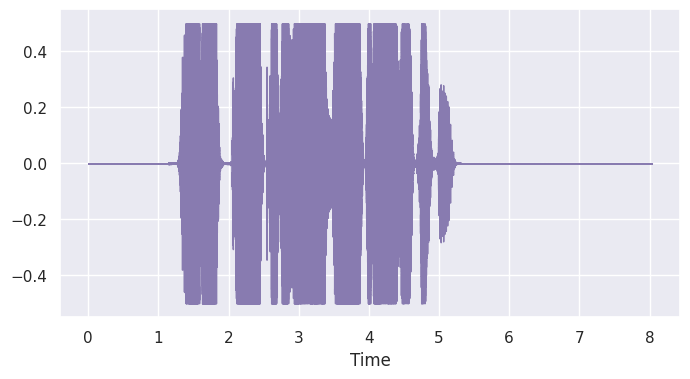

In [ ]:
fear = audio_df[audio_df['Label'] == 'FEAR']['Filepath']
feararray = audio_df[audio_df['Label'] == 'FEAR']['Arrays']

librosa.display.waveshow(feararray.iloc[0], color='#887BB0')
IPython.display.Audio(fear.iloc[0])

# SURPRISE

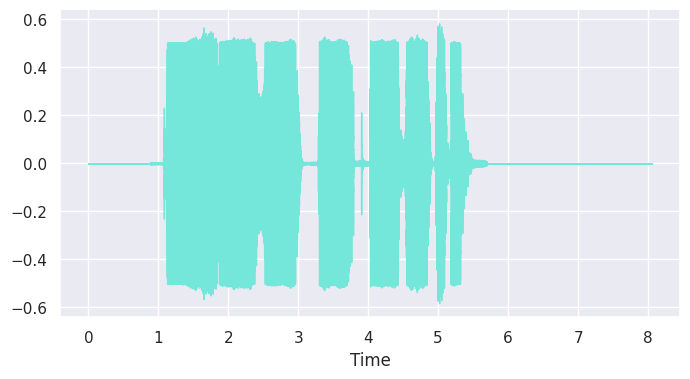

In [ ]:
surprise = audio_df[audio_df['Label'] == 'SURPRISE']['Filepath']
surprisearray = audio_df[audio_df['Label'] == 'SURPRISE']['Arrays']

librosa.display.waveshow(surprisearray.iloc[0], color='#75E6DA')
IPython.display.Audio(surprise.iloc[0])

# SAD

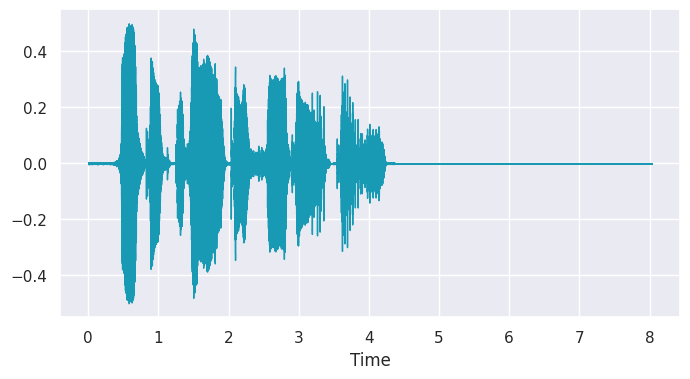

In [ ]:
sad = audio_df[audio_df['Label'] == 'SAD']['Filepath']
sadarray = audio_df[audio_df['Label'] == 'SAD']['Arrays']

librosa.display.waveshow(sadarray.iloc[0], color='#189AB4')
IPython.display.Audio(sad.iloc[0])

# DISGUST

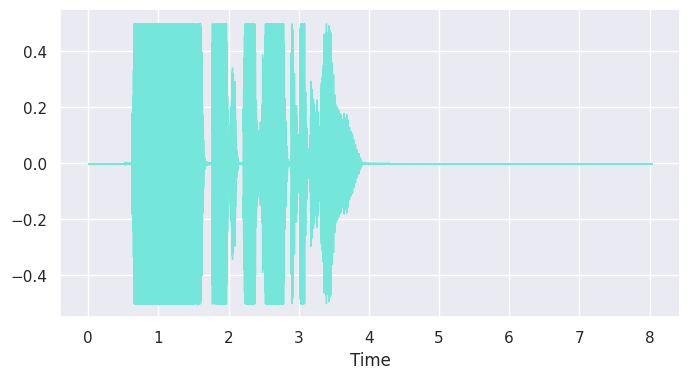

In [ ]:
disgust = audio_df[audio_df['Label'] == 'DISGUST']['Filepath']
disgustarray = audio_df[audio_df['Label'] == 'DISGUST']['Arrays']

librosa.display.waveshow(disgustarray.iloc[0], color='#75E6DA')
IPython.display.Audio(disgust.iloc[0])

# HAPPY

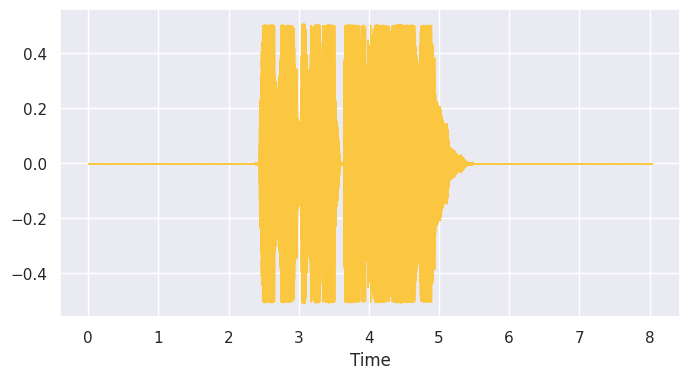

In [ ]:
happy = audio_df[audio_df['Label'] == 'HAPPY']['Filepath']
happyarray = audio_df[audio_df['Label'] == 'HAPPY']['Arrays']

librosa.display.waveshow(happyarray.iloc[0], color='#FBC740')
IPython.display.Audio(happy.iloc[0])

# NEUTRAL LABEL

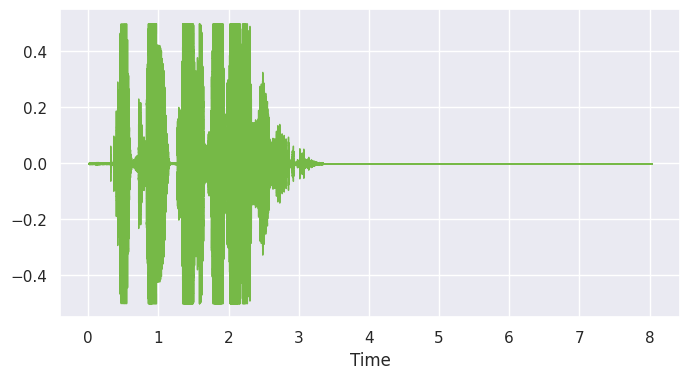

In [ ]:
neutral = audio_df[audio_df['Label'] == 'NEUTRAL']['Filepath']
neutralarray = audio_df[audio_df['Label'] == 'NEUTRAL']['Arrays']

librosa.display.waveshow(neutralarray.iloc[0], color='#76B947')
IPython.display.Audio(neutral.iloc[0])

# Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps = 4)

# taking any example and checking for techniques.
path = np.array(audio_df.Filepath)[1]
data, sample_rate = librosa.load(path)

# Extracting Features

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
     # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(data)), sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))


    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # Duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Without AUGMENTATION
    res1 = extract_features(data)
    result = np.array(res1)

    # Data with NOISE
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # Data with NOISE is distinct from data with STRETCHING and PITCHING

    # Data with STRETCHING and PITCHING
    new_data = stretch(data, sample_rate)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for index, path, emotion in zip(audio_df.Index, audio_df.Filepath, audio_df.Label):
    feature = get_features(path)
    if (index % 100 == 0):
            print("Import Data: RUNNING ... {} files".format(index))
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print(len(X))
print(len(Y))
print(audio_df.Filepath.shape)
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

# Data Preparation and Normalization
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(X.shape)
print(Y.shape)

Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
Import Data: RUNNING ... 600 files
Import Data: RUNNING ... 700 files
Import Data: RUNNING ... 800 files
Import Data: RUNNING ... 900 files
Import Data: RUNNING ... 1000 files
Import Data: RUNNING ... 1100 files
Import Data: RUNNING ... 1200 files
Import Data: RUNNING ... 1300 files
Import Data: RUNNING ... 1400 files
Import Data: RUNNING ... 1500 files
Import Data: RUNNING ... 1600 files
Import Data: RUNNING ... 1700 files
Import Data: RUNNING ... 1800 files
Import Data: RUNNING ... 1900 files
Import Data: RUNNING ... 2000 files
Import Data: RUNNING ... 2100 files
Import Data: RUNNING ... 2200 files
Import Data: RUNNING ... 2300 files
Import Data: RUNNING ... 2400 files
Import Data: RUNNING ... 2500 files
Import Data: RUNNING ... 2600 files
Import Data: RUNNING ... 2700 files
Impo

# Splitting Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.1)

print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))


((18900, 169), (18900, 7), (2100, 169), (2100, 7))
((18900, 169, 1), (18900, 7), (2100, 169, 1), (2100, 7))


# Model

In [ ]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax')) # Changed the number of neurons to 7 to match the number of classes in y_train

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(learning_rate=0.0005),
             metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 167, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 167, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 165, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 165, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 163, 512)            │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 163, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 161, 1024)           │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 161, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 164864)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      84,410,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,642,695 (330.52 MB)

 Trainable params: 86,642,695 (330.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 90s 292ms/step - accuracy: 0.2579 - loss: 3.1584 - val_accuracy: 0.5000 - val_loss: 1.3571
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.4515 - loss: 1.4021 - val_accuracy: 0.5829 - val_loss: 1.0817
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.5745 - loss: 1.1068 - val_accuracy: 0.6595 - val_loss: 0.9425
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.6606 - loss: 0.8965 - val_accuracy: 0.6905 - val_loss: 0.8198
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.7448 - loss: 0.6955 - val_accuracy: 0.7890 - val_loss: 0.5955
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.8030 - loss: 0.5464 - val_accuracy: 0.8424 - val_loss: 0.4768
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.8461 - loss: 0.4373 - val_accuracy: 0.8205 - val_loss: 0.5333
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.8790 - loss: 0

# Evaluating Model

66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'key'

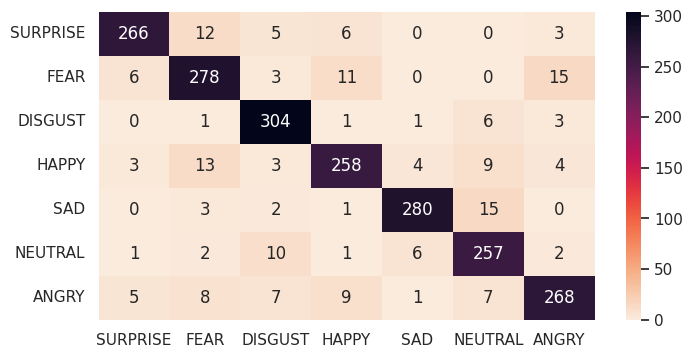

In [ ]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True,
                 fmt="d",
                 cmap = 'rocket_r',
                 xticklabels = ['SURPRISE', 'FEAR', 'DISGUST', 'HAPPY', 'SAD', 'NEUTRAL', 'ANGRY'],
                 yticklabels = ['SURPRISE', 'FEAR', 'DISGUST', 'HAPPY', 'SAD', 'NEUTRAL', 'ANGRY'])
matrix.key()

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


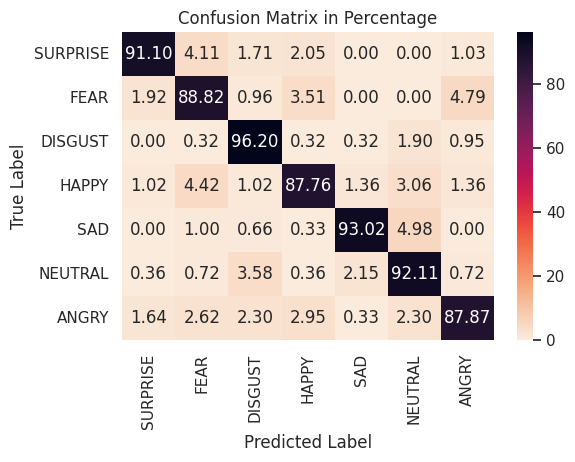

              precision    recall  f1-score   support

    SURPRISE       0.95      0.91      0.93       292
        FEAR       0.88      0.89      0.88       313
     DISGUST       0.91      0.96      0.94       316
       HAPPY       0.90      0.88      0.89       294
         SAD       0.96      0.93      0.94       301
     NEUTRAL       0.87      0.92      0.90       279
       ANGRY       0.91      0.88      0.89       305

    accuracy                           0.91      2100
   macro avg       0.91      0.91      0.91      2100
weighted avg       0.91      0.91      0.91      2100



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test data
y_pred = model.predict(x_test)

# Convert predictions and true labels to class indices
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

# Compute the confusion matrix
matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Convert the confusion matrix to percentage
matrix_percentage = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentage annotations
plt.figure(figsize=(6, 4))
ax = sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap='rocket_r',
                 xticklabels=['SURPRISE', 'FEAR', 'DISGUST', 'HAPPY', 'SAD', 'NEUTRAL', 'ANGRY'],
                 yticklabels=['SURPRISE', 'FEAR', 'DISGUST', 'HAPPY', 'SAD', 'NEUTRAL', 'ANGRY'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix in Percentage")
plt.show()

# Print the classification report for precision, recall, and F1 score
report = classification_report(y_true_labels, y_pred_labels,
                               target_names=['SURPRISE', 'FEAR', 'DISGUST', 'HAPPY', 'SAD', 'NEUTRAL', 'ANGRY'])
print(report)


# Test

In [ ]:
import random
import librosa
import numpy as np

# Define the emotion labels (update this if necessary)
emotion_labels = ['SURPRISE', 'FEAR', 'DISGUST', 'HAPPY', 'SAD', 'NEUTRAL', 'ANGRY']

# Function to extract features (same as used during training)
def extract_features(data, sample_rate):
    result = np.array([])

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma STFT
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Energy
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Function to test a random audio file from the test dataset
def test_random_audio(x_test, y_test, model):
    # Select a random index from the test set
    random_index = random.randint(0, len(x_test) - 1)

    # Get the audio features and true label
    features = x_test[random_index].reshape(1, -1, 1)
    true_label = np.argmax(y_test[random_index])
    true_emotion = emotion_labels[true_label]

    # Make a prediction
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_label]

    # Display the true and predicted labels
    print(f"True Emotion: {true_emotion}")
    print(f"Predicted Emotion: {predicted_emotion}")

    return true_emotion, predicted_emotion

# Example usage:
true_emotion, predicted_emotion = test_random_audio(x_test, y_test, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
True Emotion: SURPRISE
Predicted Emotion: SURPRISE
